In [233]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
pd.set_option('display.max_columns', 999)
import sqlite3
from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import spacy
nlp = spacy.load('en')

import re

In [2]:
df = pd.read_csv('../pitchfork3.csv')

df['word_count'] = df['content'].str.count('\w+')
df['adj_count'] = df['content_adj'].str.count('\w+')

df['avg_word_length'] = df['content'].str.count('[^ ]') / df['word_count']
df['adj_word_length'] = df['content_adj'].str.count('[^ ]') / df['content_adj'].str.count('\w+')
df['adj_freq'] = df['adj_count'] / df['word_count']

df['reissue'] = df['reissue'] + (df['artist'] == 'various artists').astype('int')
df['reissue'] = df['reissue'].astype(bool).astype(int)
df['new_album'] = ((df['reissue'] == 0) & (df['num_years_since_release'] <= 1)).astype(int)


In [4]:
# This loop adds data for an artist's previous reviews on Pitchfork

prev_data = []
for i in range(len(df['score'])):
    reviewid = df['reviewid'][i]
    artist = df['artist'][i]
    sub_df = df[(df['pub_date'] < df['pub_date'][i]) & (df['artist'] == df['artist'][i])]
    if df['artist'][i] == 'various artists':
        num_reviews = 1
        num_bnm = 0
    else:
        num_reviews = sub_df['score'].count() + 1
        num_bnm = sub_df['best_new_music'].sum()
    if num_reviews == 1:
        avg_scores = df['score'][i]
    else:
        avg_scores = sub_df['score'].mean()
    
    prev_data.append((reviewid, artist, num_reviews, avg_scores, num_bnm))

df_prev = pd.DataFrame(prev_data, columns =['reviewid', 'artist', 'num_prev_reviews', 'avg_score_of_prev_reviews', 'number_prev_bnm'])

df = df.merge(df_prev)

In [3]:
values_dict = {1999: '1999-2002', 
               2000: '1999-2002', 
               2001: '1999-2002', 
               2002: '1999-2002', 
               2003: '2003-2005',
               2004: '2003-2005',
              2005:  '2003-2005',
              2006:  '2006-2010', 
              2007:  '2006-2010', 
              2008:  '2006-2010', 
              2009:  '2006-2010', 
              2010:  '2006-2010', 
              2011:  '2011-2015', 
              2012:  '2011-2015', 
              2013:  '2011-2015', 
               2014:  '2011-2015', 
               2015:  '2011-2015',  
               2016:  '2016-2017', 
               2017:  '2016-2017', 
              }

df['era'] = df['pub_year'].map(values_dict)

In [205]:
df_auth_count = df.groupby(['author']).count().reset_index()[['author', 'reviewid']]

In [219]:
df_auth_mean = df.groupby(['author']).mean().reset_index()

In [206]:
df_auth_max = df.groupby(['author']).max().reset_index()

In [239]:
df_auth_std = df.groupby(['author']).std().reset_index()

In [234]:
df_auth_max.head()

,author,Unnamed: 0,Unnamed: 0.1,index,reviewid,title,artist,url,score,best_new_music,best_new_reissue,pub_date,pub_weekday,pub_day,pub_month,pub_year,year,genre_electronic,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock,content,abstract,reissue,num_years_since_release,new_album,abstract_adj,content_adj,cont_polarity,cont_subjectivity,abs_polarity,abs_subjectivity,abs_adj_polarity,abs_adj_subjectivity,cont_adj_polarity,cont_adj_subjectivity,word_count,adj_count,adj_freq,score_bin,avg_word_length,adj_word_length,num_prev_reviews,avg_score_of_prev_reviews,number_prev_bnm,era
0,aaron leitko,12092,12092,12557,5929e796eb335119a49ef3ac,young people's church of the air,women,https://pitchfork.com/reviews/albums/21820-get...,8.8,1,1,2016-05-12,4,31,12,2016,2016,1,1,1,1,1,1,1,1,1,Written and recorded around 2007 after Redd Kr...,Written and recorded around 2007 after Redd Kr...,1,34,1,unofficial permanent dissonant recent,unofficial permanent dissonant recent last sev...,0.225825,0.590253,0.558333,0.762500,0.700000,1.000000,0.170219,0.608817,1288.0,106.0,0.121294,8,5.217742,7.962963,11,9.0,0,2016-2017
1,abby garnett,4366,4366,4592,5929e2fc13d197565213d665,the phoenix,mark e,https://pitchfork.com/reviews/albums/21050-i-n...,7.6,0,0,2015-10-05,3,25,11,2015,2015,1,0,0,0,0,0,1,0,0,With a career that s almost passed the two dec...,With a career that s almost passed the two dec...,1,0,1,new,new scrappy aesthetic obvious efficient techni...,0.234149,0.537511,0.418182,0.677273,0.212121,0.484848,0.178499,0.548939,717.0,85.0,0.119626,7,5.041841,7.352941,5,7.6,0,2011-2015
2,abigail covington,2320,2320,2443,5929dca613d197565213cfd1,in my mind,towkio,https://pitchfork.com/reviews/albums/22138-com...,7.6,0,0,2016-07-20,3,25,7,2016,2016,0,0,0,0,0,0,0,1,0,Chance the Rapper compatriot Towkio sometimes ...,Chance the Rapper compatriot Towkio sometimes ...,0,0,1,great vivid funny weird cruddy generic,great vivid funny weird cruddy generic high pu...,0.168972,0.496499,0.119792,0.635714,0.159722,0.733333,0.240901,0.536151,646.0,41.0,0.064205,7,4.451043,6.682927,2,7.6,0,2016-2017
3,abigail garnett,3364,3364,3534,5929dfe7c0084474cd0c4ac4,tundra,lakker,https://pitchfork.com/reviews/albums/20968-tet...,7.8,0,0,2015-09-02,2,31,9,2015,2015,1,0,0,0,0,0,0,0,0,Tundra Lakker s second album in a decade delve...,Tundra Lakker s second album in a decade delve...,0,0,1,second electronic sacred alive,second electronic sacred alive curious human e...,0.194376,0.515231,0.193333,0.478395,0.400000,0.700000,0.163333,0.569482,699.0,73.0,0.106173,7,4.882690,7.372093,1,7.8,0,2011-2015
4,adam dlugacz,18807,18807,19571,5929dc88eb335119a49ee9e6,united by fate,rival schools,https://pitchfork.com/reviews/albums/6794-unit...,6.3,0,0,2001-10-02,1,2,10,2001,2001,0,0,0,0,0,1,0,0,1,Now that we have seen the golden age of hardco...,Now that we have seen the golden age of hardco...,0,0,1,golden,golden golden young angry white whole fun high...,0.052430,0.446119,0.300000,0.500000,0.300000,0.500000,0.031887,0.446165,653.0,51.0,0.078101,6,4.442573,5.529412,1,6.3,0,1999-2002


In [240]:
df_auth = df_auth_std.merge(df_auth_count, on='author')

In [241]:
df_auth

,author,Unnamed: 0,Unnamed: 0.1,index,score,best_new_music,best_new_reissue,pub_weekday,pub_day,pub_month,pub_year,year,genre_electronic,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock,reissue,num_years_since_release,new_album,cont_polarity,cont_subjectivity,abs_polarity,abs_subjectivity,abs_adj_polarity,abs_adj_subjectivity,cont_adj_polarity,cont_adj_subjectivity,word_count,adj_count,adj_freq,score_bin,avg_word_length,adj_word_length,num_prev_reviews,avg_score_of_prev_reviews,number_prev_bnm,reviewid
0,aaron leitko,2896.839610,2896.839610,2993.331255,0.783928,0.188897,0.155207,1.427354,9.266253,3.274572,2.499624,5.454929,0.298546,0.477119,0.188897,0.110432,0.188897,0.216734,0.110432,0.110432,0.503077,0.281145,5.270934,0.314509,0.055958,0.051277,0.165804,0.182395,0.188357,0.239345,0.061316,0.058317,159.341614,14.261041,0.013992,0.850191,0.197143,0.543604,1.527082,0.821209,0.000000,82
1,abby garnett,633.989195,633.989195,664.547064,0.491935,0.000000,0.000000,1.303840,8.642916,3.674235,0.547723,0.547723,0.447214,0.000000,0.000000,0.000000,0.000000,0.000000,0.447214,0.000000,0.000000,0.447214,0.000000,0.447214,0.056637,0.062262,0.179560,0.221990,0.097932,0.140211,0.059659,0.066345,126.540507,15.385058,0.014653,0.547723,0.073280,0.366593,1.732051,0.665582,0.000000,5
2,abigail covington,367.695526,367.695526,392.444264,0.777817,0.000000,0.000000,0.707107,3.535534,3.535534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042690,0.053102,0.115010,0.255064,0.139457,0.282843,0.102747,0.019099,16.263456,0.707107,0.000522,0.707107,0.189774,0.518258,0.707107,0.989949,0.000000,2
3,abigail garnett,258.747625,258.747625,268.799182,0.435890,0.000000,0.000000,0.577350,14.640128,3.055050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080974,0.031078,0.124350,0.059892,0.175594,0.275379,0.039590,0.041634,149.379829,16.772994,0.009492,0.000000,0.120433,0.330579,0.000000,0.435890,0.000000,3
4,adam dlugacz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,adam moerder,1534.429703,1534.429703,1603.465614,1.357246,0.073521,0.000000,1.617926,8.537596,3.189362,1.267834,2.682931,0.469392,0.330847,0.203956,0.000000,0.073521,0.162602,0.256296,0.000000,0.408991,0.191322,2.583642,0.203956,0.055977,0.050848,0.198869,0.260505,0.212469,0.310178,0.072878,0.068287,78.083862,9.520968,0.013860,1.408323,0.151898,0.438459,1.387962,1.367166,0.203956,185
6,adam ohler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,adrienne day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,al shipley,76.515975,76.515975,77.309623,1.411559,0.000000,0.000000,1.333333,6.670832,2.351123,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.440959,0.000000,0.333333,0.000000,0.527046,0.440959,0.000000,0.440959,0.047139,0.033533,0.194942,0.133682,0.225863,0.370852,0.054294,0.055114,202.541422,18.100031,0.014181,1.424001,0.100971,0.302934,0.666667,1.432219,0.000000,9
9,alan light,292.035101,292.035101,310.419877,0.848528,0.000000,0.000000,1.414214,5.656854,2.828427,0.000000,6.363961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,6.363961,0.000000,0.024581,0.018981,0.036534,0.095459,0.159099,0.194454,0.037746,0.037329,62.932504,2.828427,0.003834,1.414214,0.072290,0.193880,0.000000,0.848528,0.000000,2


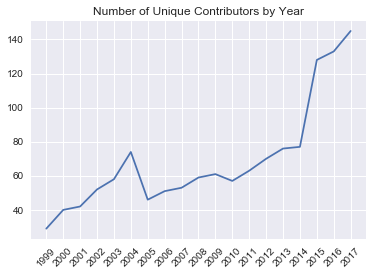

In [222]:
df_num_contributors = pd.DataFrame(df.groupby(['pub_year'])['author'].unique()).reset_index()
df_num_contributors['num_authors'] = df_num_contributors['author'].map(lambda x: len(x))

plt.title('Number of Unique Contributors by Year')
plt.plot(df_num_contributors['pub_year'], df_num_contributors['num_authors'])
plt.xticks(range(1999,2018), rotation=45)
plt.show()

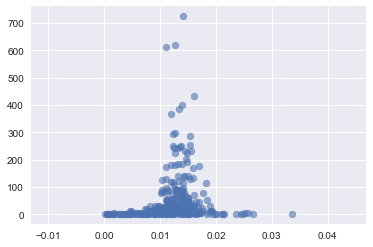

In [242]:
plt.scatter(df_auth['adj_freq'], df_auth['reviewid'], alpha=.6)

In [230]:
df_auth.describe()

,Unnamed: 0,Unnamed: 0.1,index,score,best_new_music,best_new_reissue,pub_weekday,pub_day,pub_month,pub_year,...,word_count,adj_count,adj_freq,score_bin,avg_word_length,adj_word_length,num_prev_reviews,avg_score_of_prev_reviews,number_prev_bnm,reviewid
count,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,...,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000
mean,8942.581239,8942.581239,9314.561535,7.063587,0.048244,0.023420,2.235933,15.816749,6.438268,2009.834778,...,762.808628,64.355100,0.085770,6.632740,4.630314,6.531747,1.738796,7.078763,0.044816,35.955414
std,7015.149416,7015.149416,7287.594979,0.875940,0.152292,0.113735,1.139981,5.224412,2.161373,6.139971,...,331.846155,26.142191,0.011805,0.891162,0.168885,0.347450,0.873190,0.822357,0.134032,79.449436
min,14.000000,14.000000,36.000000,1.700000,0.000000,0.000000,0.000000,1.000000,1.000000,1999.000000,...,348.666667,18.000000,0.044118,1.000000,4.049020,4.611111,1.000000,1.700000,0.000000,1.000000
25%,2098.730769,2098.730769,2205.073077,6.689101,0.000000,0.000000,1.666667,13.635081,5.288690,2004.000000,...,596.500000,50.875000,0.078113,6.224635,4.530568,6.336900,1.155870,6.798437,0.000000,2.000000
50%,7290.636364,7290.636364,7634.333333,7.100000,0.000000,0.000000,2.091603,15.529412,6.368421,2011.335664,...,692.666667,59.000000,0.085558,6.677419,4.617348,6.520451,1.545455,7.133333,0.000000,7.000000
75%,16443.250000,16443.250000,17109.500000,7.486607,0.029412,0.000000,2.615385,17.683333,7.549231,2015.915761,...,795.166667,69.531384,0.092837,7.000000,4.739301,6.722703,2.000000,7.486126,0.034287,30.500000
max,19614.000000,19614.000000,20385.000000,9.833333,1.000000,1.000000,6.000000,31.000000,12.000000,2017.000000,...,3220.000000,300.000000,0.131827,9.666667,5.127248,7.644444,8.000000,9.400000,1.500000,724.000000


In [252]:
df_auth = df_auth[df_auth['reviewid'] > 10]

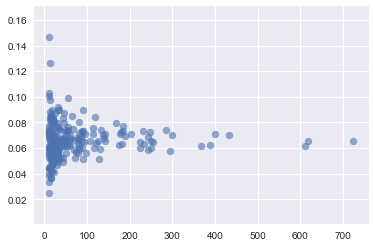

In [253]:
plt.scatter((df_auth['reviewid']), df_auth['cont_adj_polarity'], alpha=.6)
plt.show()

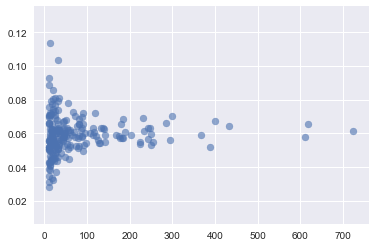

In [254]:
plt.scatter((df_auth['reviewid']), df_auth['cont_adj_subjectivity'], alpha=.6)


In [71]:
for each in authors:
    print each

In [163]:
top_authors = df_auth[df_auth['reviewid'] >250].sort_values('reviewid', ascending=False)['author'].astype(list)

In [164]:
low_authors = df_auth[df_auth['reviewid'] <5].sort_values('reviewid', ascending=False)['author'].astype(list)

In [165]:
df_top_authors = df[df['author'].isin(top_authors)]

In [145]:
df_low_authors = df[df['author'].isin(low_authors)]

In [150]:
df_low_authors.groupby('pub_year')['abs_polarity'].mean()

pub_year
1999    0.058868
2000    0.058340
2001    0.157660
2002    0.098674
2003    0.056269
2004    0.081421
2005    0.051767
2006    0.004167
2007    0.218757
2008    0.037500
2009    0.139587
2010    0.186364
2011    0.220278
2012    0.183718
2013    0.167553
2014    0.144563
2015    0.145506
2016    0.149290
2017    0.163867
Name: abs_polarity, dtype: float64

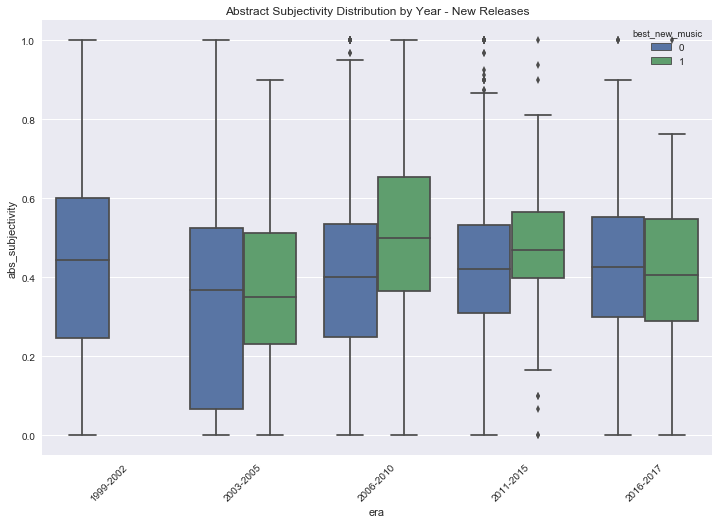

In [171]:
plt.figure(figsize=(12,8))
temp_df = df_top_authors
temp_df2 = df_low_authors
sns.boxplot(x=temp_df['era'][::-1], y=temp_df['abs_subjectivity'], data=temp_df[['abs_subjectivity', 'era']], hue=temp_df['best_new_music'])
# sns.boxplot(x=temp_df2['era'][::-1], y=temp_df2['abs_subjectivity'], data=temp_df2[['abs_subjectivity', 'era']])

plt.title('Abstract Subjectivity Distribution by Year - New Releases')
# plt.yticks(np.arange(0,11))

plt.xticks(rotation=45)
plt.show()

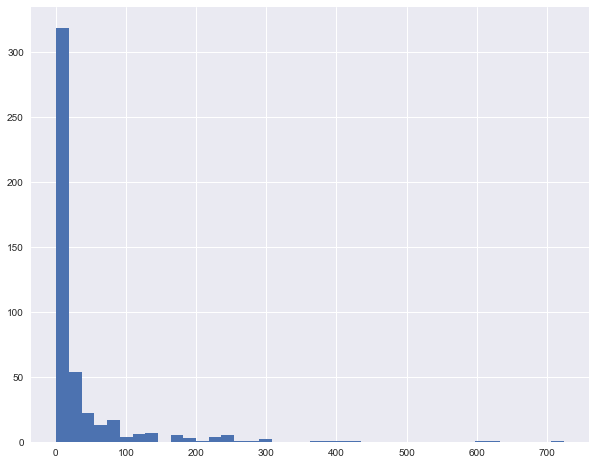

In [92]:
plt.figure(figsize=(10,8))
plt.hist(df_auth['reviewid'], bins=40)
plt.show()

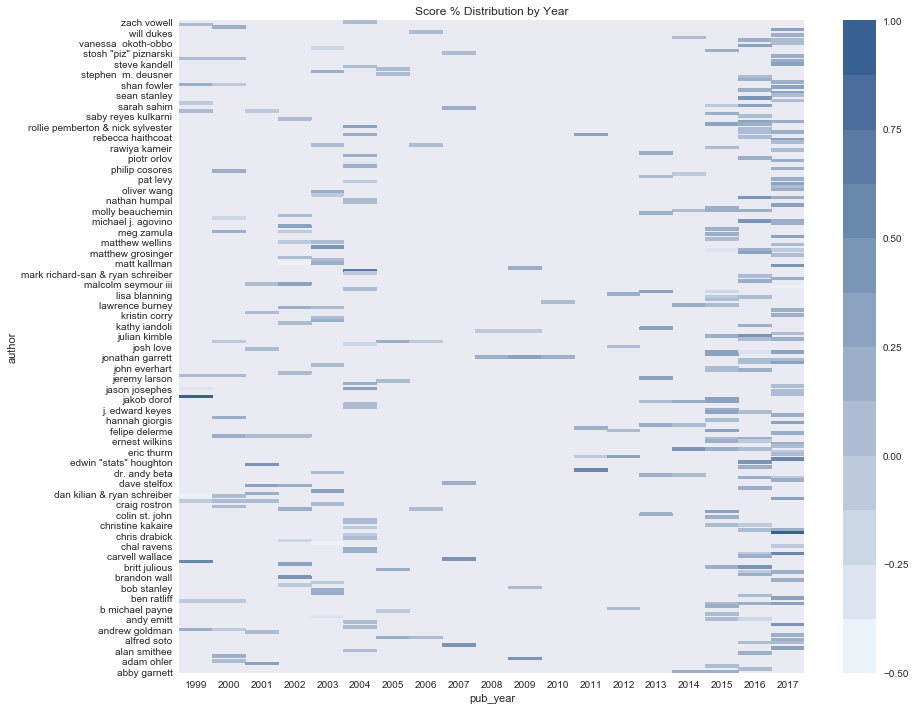

In [99]:
temp_df = pd.DataFrame(df_top_authors.groupby(['pub_year', 'author'])['abs_polarity'].mean()).reset_index()
heatmap_df = temp_df.pivot(index='author', columns='pub_year', values='abs_polarity')
# df_norm_col=(heatmap_df)/heatmap_df.sum()

plt.figure(figsize=(14,12))
plt.title("Score % Distribution by Year")
plt.xlabel('Year')

plt.ylabel('Score')
sns.heatmap(heatmap_df[::-1], 
#             annot=(heatmap_df[::-1]).round(3), 
#             norm=LogNorm(vmin=0, vmax=1), 
#             fmt='.1%', 
            cmap=sns.light_palette((250, 70, 40), input='husl', n_colors=12)
           )
plt.show()